Importamos las librerías necesarias

In [8]:
import matplotlib.pyplot as plt
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF, SVD
from cornac.models import Recommender
from cornac.eval_methods import RatioSplit

Crear modelos propios

In [9]:
class Hybrid(cornac.models.Recommender):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(name=name)
        self.models = models
        self.weights = weights

    def fit(self, train_set, eval_set):
        super().fit(train_set,eval_set)
        for m in self.models:
            m.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None):
        ponderated_sum = 0
        # if each weight is 1/len(weights) is the average  
        for idx in range(len(self.models)):
            ponderated_sum += self.models[idx].score(user_idx, item_idx)*self.weights[idx]

        return ponderated_sum/sum(self.weights)
    
class KFN(cornac.models.Recommender):
    def __init__(self, name="KFN"):
        super().__init__(name)
        
    def fit(self, train_set, val_set=None):
        super().fit(train_set, val_set)
    def score(self, user_idx, item_idx=None):
        return 1
    def recommend(self, user_id, k=-1, remove_seen=False, train_set=None):
        return super().recommend(user_id, k, remove_seen, train_set)
    
class DHybrid(Hybrid):
    def __init__(self, models, weights, name="Hybrid"):
        super().__init__(models, weights, name)
        self.kfn = KFN("KFN")
        
    def fit(self, train_set, eval_set):
        super().fit(train_set, eval_set)
        self.kfn.fit(train_set, eval_set)
        
    def score(self, user_idx, item_idx=None):
        return super().score(user_idx, item_idx)
    
    def recommend(self, user_id, k=-1, remove_seen=False, train_set=None, n = 3):
        recommendations = super().recommend(user_id, k, remove_seen, train_set)
        if n < len(recommendations):
            recommendations[-n:] = self.kfn.recommend[:n]
        return recommendations
    

Cargar el dataset de MovieLens 100K

In [10]:
data = movielens.load_feedback()

Definir el método de evaluación

In [11]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)

rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1642
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1642
Number of ratings = 19954
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1642


Definir los modelos a emplear

In [12]:
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = DHybrid([svd, bpr, knn], (6,3,1))


Definir las metricas a utilizar

In [13]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento


In [14]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mf, bpr, svd, knn, hybrid], metrics=metrics)

Ejecutar el experimento

In [15]:
experiment.run()


[MF] Training started!



[MF] Evaluation started!


Rating:   0%|          | 0/19954 [00:00<?, ?it/s]

Ranking:   0%|          | 0/939 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19954 [00:00<?, ?it/s]

Ranking:   0%|          | 0/939 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19954 [00:00<?, ?it/s]

Ranking:   0%|          | 0/939 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1642 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19954 [00:00<?, ?it/s]

Ranking:   0%|          | 0/939 [00:00<?, ?it/s]


[Hybrid] Training started!


/usr/local/lib/python3.12/dist-packages/cornac/models/recommender.py:322: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(


  0%|          | 0/1642 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19954 [00:00<?, ?it/s]

Ranking:   0%|          | 0/939 [00:00<?, ?it/s]


TEST:
...
        |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------------ + --------- + --------- + --------
MF      | 0.7285 | 0.8857 |       0.0785 |    0.0562 |    0.5684 |   6.0155
BPR     | 2.1554 | 2.3486 |       0.1111 |    0.1178 |    0.2973 |   6.0883
SVD     | 0.7365 | 0.8950 |       0.0658 |    0.0450 |    0.0805 |   2.8992
ItemKNN | 0.8125 | 0.9841 |       0.0288 |    0.0165 |    0.3590 |  14.4177
Hybrid  | 0.9619 | 1.1220 |       0.1623 |    0.1441 |    0.7005 |  34.9601



Extraer los resultados de las métricas

In [16]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

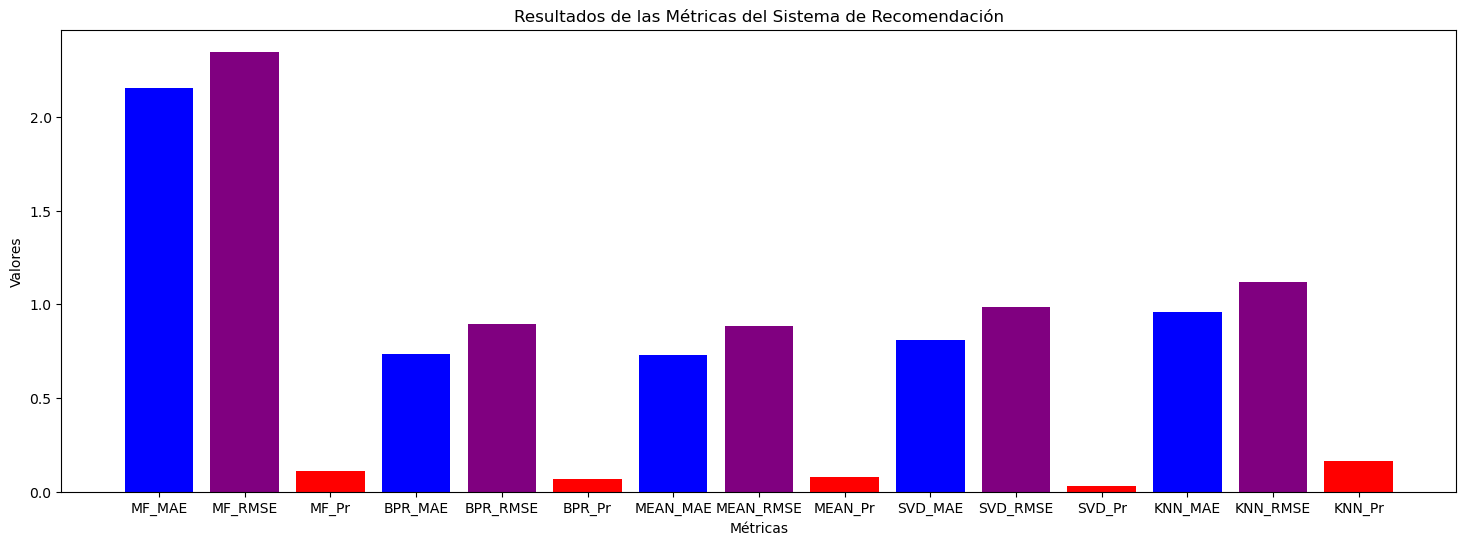

In [17]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
